In [1]:
from IPython.display import display
from model.utility.default_parameters import default_params_soros as params
from model.utility.default_initial_state import default_initial_soros as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run, post_processing


params['soros_short_amount'] = [0, 250000, 500000, 750000, 1000000] * 2
params['soros_short_timing'] = [None, 50, 50, 50, 50]* 2
params['soros_close_out_timing'] = [55, 55, 55, 55, 55]* 2
params['soros_long_position'] = [500000, 500000, 500000, 500000, 500000]* 2

params["lower_wall"] = [.15] * 5 + [.3] * 5
params["upper_wall"] = [.15] * 5 + [.3] * 5
params["upper_wall"] = [.075] * 5 + [.15] * 5
params["upper_wall"] = [.075] * 5 + [.15] * 5

# Fill in initial state
initial_state = fill_in_initial_state(initial_state, params)

# Set the params for runs and timesteps
number_runs = 10
number_steps = 100

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,
                 psub_scenario_option = "Soros")

# Run the experiment
raw = run(exp)

# Parse the raw data
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 26, 100, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 26, 100, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 514.10s


In [2]:
df.to_csv("soros_runs.csv")

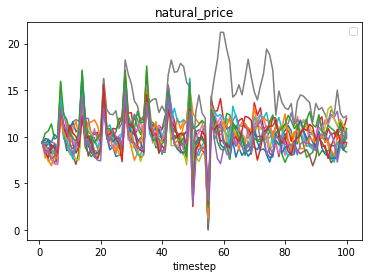

In [3]:
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

plot_all_sims(["natural_price"], df)

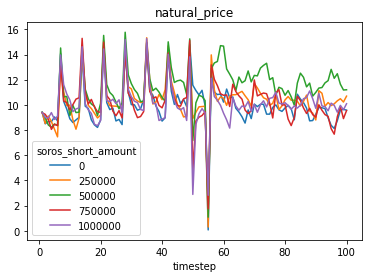

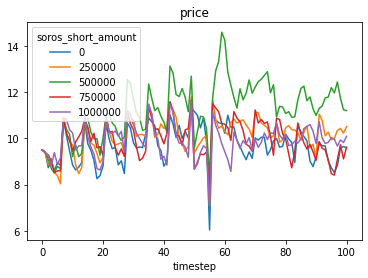

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [4]:
# Plot the average values for natural price by the groups of supply and demand factor
variables_to_plot = ["natural_price", "price"]
grouping_variables = ["soros_short_amount"]

plot_grouped_variables_average(variables_to_plot,
                               grouping_variables,
                               df)

In [6]:
df.groupby("subset").sum()["soros_revenue"]

subset
0    5.078017e+07
1    5.204562e+07
2    5.887286e+07
3    5.355909e+07
4    5.195832e+07
Name: soros_revenue, dtype: float64

In [7]:
df.pivot("timestep", "unique_id", "soros_revenue").sum()

unique_id
0-0-1    1.540831e+07
0-0-2    1.712899e+07
0-0-3    1.824287e+07
0-1-1    1.646362e+07
0-1-2    1.769187e+07
0-1-3    1.789013e+07
0-2-1    1.955492e+07
0-2-2    2.310494e+07
0-2-3    1.621300e+07
0-3-1    1.867635e+07
0-3-2    1.786673e+07
0-3-3    1.701601e+07
0-4-1    1.730151e+07
0-4-2    1.829324e+07
0-4-3    1.636358e+07
dtype: float64

In [8]:
import pandas as pd
revenue = df.groupby("unique_id")[["soros_revenue"]].sum()
descriptors = df.groupby("unique_id")[['soros_short_amount',
 'soros_short_timing',
 'soros_close_out_timing',
 'soros_long_position']].last()
df2 = pd.concat([revenue, descriptors], axis=1)

In [9]:
df2

,soros_revenue,soros_short_amount,soros_short_timing,soros_close_out_timing,soros_long_position
unique_id,,,,,
0-0-1,1.540831e+07,0,NaN,55,2000000
0-0-2,1.712899e+07,0,NaN,55,2000000
0-0-3,1.824287e+07,0,NaN,55,2000000
0-1-1,1.646362e+07,250000,50.0,55,2000000
0-1-2,1.769187e+07,250000,50.0,55,2000000
0-1-3,1.789013e+07,250000,50.0,55,2000000
0-2-1,1.955492e+07,500000,50.0,55,2000000
0-2-2,2.310494e+07,500000,50.0,55,2000000
0-2-3,1.621300e+07,500000,50.0,55,2000000


In [11]:
baseline_values = df2[df2["soros_short_amount"] == 0]
baseline_values

,soros_revenue,soros_short_amount,soros_short_timing,soros_close_out_timing,soros_long_position
unique_id,,,,,
0-0-1,1.540831e+07,0,NaN,55,2000000
0-0-2,1.712899e+07,0,NaN,55,2000000
0-0-3,1.824287e+07,0,NaN,55,2000000
